In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio import Align
from scipy import spatial
import scipy.stats
import tqdm

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, plot_mutspec192kk
from pymutspec.draw.sbs_orders import ordered_sbs192_kp as ordered_sbs192

sns.set_style("whitegrid")
coda = CodonAnnotation(2)

In [2]:
transitions = ["A>G","G>A","T>C","C>T"]
transversions = [x for x in possible_sbs12 if x not in transitions]

In [3]:
def nuc_freqs2sbsfreqs(nuc_freqs: dict) -> dict:
    nucs = "ACGT"
    for nuc in nucs:
        assert nuc in nuc_freqs

    sbs_freqs = dict()
    for nuc1 in nucs:
        for nuc2 in nucs:
            if nuc1 != nuc2:
                sbs_freqs[f"{nuc1}>{nuc2}"] = nuc_freqs[nuc1]
    return sbs_freqs

## GTEx (mtRNA)

In [4]:
gtex = pd.read_csv("../data/external/GTExRef.txt", )
gb_refseq_gtex = next(SeqIO.parse("../data/external/gtex_refseq.gb", "gb"))

assert (gtex.AncestralAllele == gtex.Position.map({i:x for i, x in enumerate(gb_refseq_gtex.seq, 1)})).all()

refseq_gtex = read_genbank_ref(gb_refseq_gtex)
refseq_gtex.loc[refseq_gtex["Codon"] == "TA", "Codon"] = "TAA"

gtex["Substitution"] = gtex.Substitution.str.replace("_", ">")
print(gtex.shape)
gtex.head()

(2565, 14)


,Position,Mutation,SRR,AF,tissue,subject,nDonorTissue,BQ,COV,OTHERS_DONOR_AF,OTHERS_DONOR_COV,DerivedAllele,AncestralAllele,Substitution
0,1554,1554_A,SRR1500555,0.1021,Artery - Tibial,GTEX-1117F,13,35.7,186,0.0012,1241.3,A,G,G>A
1,16215,16215_A,SRR1413373,0.0525,Ovary,GTEX-1117F,13,37.9,362,0.0000,1421.8,A,G,G>A
2,4006,4006_G,SRR1413373,0.0930,Ovary,GTEX-1117F,13,37.5,3418,0.0001,31757.6,G,A,A>G
3,458,458_T,SRR1413373,0.0340,Ovary,GTEX-1117F,13,35.1,206,0.0000,614.0,T,C,C>T
4,67,67_A,SRR1309070,0.0604,Muscle - Skeletal,GTEX-1117F,13,35.5,745,0.0003,590.0,A,G,G>A


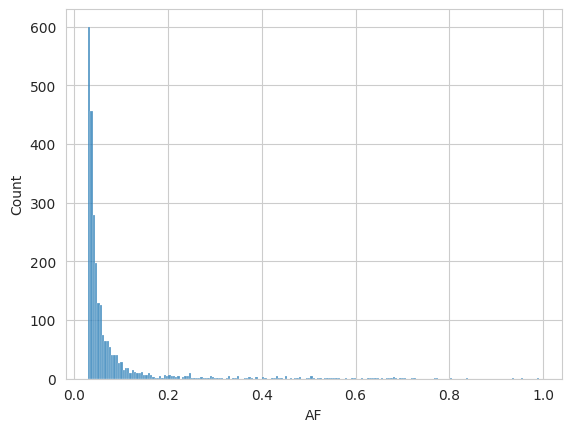

In [5]:
sns.histplot(gtex.AF);

In [6]:
gtex_filtered = gtex.merge(refseq_gtex, left_on="Position", right_on="Pos")
assert (gtex_filtered.Nuc == gtex_filtered.AncestralAllele).all()
assert gtex_filtered.shape[0] == gtex.shape[0]

gtex_filtered["Mut"] = gtex_filtered.Context.str.get(0) + "[" + gtex_filtered.Substitution + "]" + gtex_filtered.Context.str.get(-1)
gtex_filtered = gtex_filtered[(gtex_filtered.Type == "CDS") & (gtex_filtered.Strand == 1)]
gtex_filtered["AltCodon"] = gtex_filtered.apply(lambda x: "".join([x.Codon[i] if i != x.PosInCodon-1 else x.DerivedAllele for i in range(3)]), axis=1)
gtex_filtered["Label"] = gtex_filtered.apply(lambda x: coda.get_mut_type(x.Codon, x.AltCodon, x.PosInCodon-1)[0], axis=1)
print(gtex_filtered.shape)
gtex_filtered.head()

(1252, 26)


,Position,Mutation,SRR,AF,tissue,subject,nDonorTissue,BQ,COV,OTHERS_DONOR_AF,...,Context,Strand,Type,product,PosInGene,PosInCodon,Codon,Mut,AltCodon,Label
5,4006,4006_G,SRR1413373,0.0930,Ovary,GTEX-1117F,13,37.5,3418,0.0001,...,TAA,1,CDS,NADH dehydrogenase subunit 1,699,3,ATA,T[A>G]A,ATG,1
6,4006,4006_G,SRR659169,0.0366,Whole Blood,GTEX-QDT8,29,29.5,1529,0.0005,...,TAA,1,CDS,NADH dehydrogenase subunit 1,699,3,ATA,T[A>G]A,ATG,1
7,4006,4006_G,SRR660042,0.0306,Whole Blood,GTEX-SNMC,15,33.6,1959,0.0004,...,TAA,1,CDS,NADH dehydrogenase subunit 1,699,3,ATA,T[A>G]A,ATG,1
21,7029,7029_C,SRR1413373,0.0364,Ovary,GTEX-1117F,13,37.4,4233,0.0014,...,CTC,1,CDS,cytochrome c oxidase subunit I,1125,3,GCT,C[T>C]C,GCC,2
22,7029,7029_C,SRR1456591,0.0457,Thyroid,GTEX-11P82,21,37.3,157843,0.0008,...,CTC,1,CDS,cytochrome c oxidase subunit I,1125,3,GCT,C[T>C]C,GCC,2


In [7]:
refseq_gtex["SynCodons"] = refseq_gtex.apply(lambda x: coda.get_syn_codons(x.Codon, x.PosInCodon-1) if x.PosInCodon >= 0 else {}, axis=1)
refseq_gtex["Is4Fold"] = refseq_gtex["SynCodons"].apply(len) == 3

# ONLY CDS
refseq_gtex_cds = refseq_gtex[(refseq_gtex.Type == "CDS") & (refseq_gtex.Strand == 1)]

exp12all_gtex = nuc_freqs2sbsfreqs(refseq_gtex_cds.Nuc.value_counts().to_dict())


possible_syn_sbs_gtex = refseq_gtex_cds.explode("SynCodons", ignore_index=True).dropna(subset="SynCodons")
possible_syn_sbs_gtex["Nuc2"] = possible_syn_sbs_gtex.apply(lambda x: x.SynCodons[x.PosInCodon-1], axis=1)
possible_syn_sbs_gtex["Sbs"] = possible_syn_sbs_gtex["Nuc"] + ">" + possible_syn_sbs_gtex["Nuc2"]

exp12syn_gtex = possible_syn_sbs_gtex["Sbs"].value_counts().to_dict()
possible_syn_sbs_gtex.head()

,Pos,Nuc,Context,Strand,Type,product,PosInGene,PosInCodon,Codon,SynCodons,Is4Fold,Nuc2,Sbs
2,3310,A,TAC,1,CDS,NADH dehydrogenase subunit 1,3,3,ATA,ATG,False,G,A>G
5,3313,C,CCA,1,CDS,NADH dehydrogenase subunit 1,6,3,CCC,CCG,True,G,C>G
6,3313,C,CCA,1,CDS,NADH dehydrogenase subunit 1,6,3,CCC,CCA,True,A,C>A
7,3313,C,CCA,1,CDS,NADH dehydrogenase subunit 1,6,3,CCC,CCT,True,T,C>T
10,3316,G,TGG,1,CDS,NADH dehydrogenase subunit 1,9,3,ATG,ATA,False,A,G>A


## Cancer TCGA (mtDNA)

In [8]:
tcga = pd.read_csv("../data/processed/mutations.csv")
tcga_filtered = tcga[(tcga.Type == "CDS") & (tcga.Strand == 1)]
tcga_filtered["Sbs12"] = tcga_filtered.Mut.str.slice(2,5)

print(tcga_filtered.shape[0])
tcga_filtered.head()

4505


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut,Sbs12
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A,T>C
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A
5,Liver,400.0,4.8500,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A
6,Pancreas,360.0,5.7100,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C,G>A


In [9]:
refseq_rCRS = pd.read_csv("../data/processed/ref_annot.csv")
refseq_rCRS = refseq_rCRS[refseq_rCRS.Strand == 1]
refseq_rCRS["SynCodons"] = refseq_rCRS.apply(lambda x: coda.get_syn_codons(x.Codon, x.PosInCodon-1) if x.PosInCodon >= 0 else {}, axis=1)
refseq_rCRS["Is4Fold"] = refseq_rCRS["SynCodons"].apply(len) == 3

# ONLY CDS
refseq_rCRS_cds = refseq_rCRS[(refseq_rCRS.Type == "CDS")]

exp12all_tcga = nuc_freqs2sbsfreqs(refseq_rCRS_cds.Nuc.value_counts().to_dict())


possible_syn_sbs_rCRS = refseq_rCRS_cds.explode("SynCodons", ignore_index=True).dropna(subset="SynCodons")
possible_syn_sbs_rCRS["Nuc2"] = possible_syn_sbs_rCRS.apply(lambda x: x.SynCodons[x.PosInCodon-1], axis=1)
possible_syn_sbs_rCRS["Sbs"] = possible_syn_sbs_rCRS["Nuc"] + ">" + possible_syn_sbs_rCRS["Nuc2"]

exp12syn_tcga = possible_syn_sbs_rCRS["Sbs"].value_counts().to_dict()
possible_syn_sbs_rCRS.head()

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,SynCodons,Is4Fold,Nuc2,Sbs
2,3309,A,TAC,1,CDS,ND1,3,3,ATA,11745.0,ATG,False,G,A>G
5,3312,C,CCA,1,CDS,ND1,6,3,CCC,11751.0,CCG,True,G,C>G
6,3312,C,CCA,1,CDS,ND1,6,3,CCC,11751.0,CCA,True,A,C>A
7,3312,C,CCA,1,CDS,ND1,6,3,CCC,11751.0,CCT,True,T,C>T
10,3315,G,TGG,1,CDS,ND1,9,3,ATG,11757.0,ATA,False,A,G>A


## Compare spectra

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


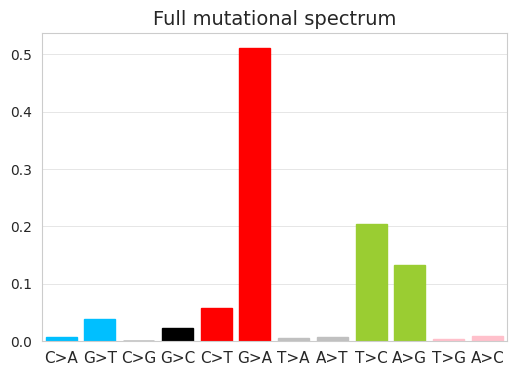

,Mut,ObsNum,ExpNum,RawMutSpec,MutSpec
0,A>C,17,3165,0.005371,0.008741
1,A>G,259,3165,0.081833,0.133173
2,A>T,13,3165,0.004107,0.006684
3,C>A,16,3581,0.004468,0.007271
4,C>T,128,3581,0.035744,0.058170
5,G>A,407,1297,0.313801,0.510675
6,G>C,18,1297,0.013878,0.022585
7,G>T,31,1297,0.023901,0.038897
8,T>A,9,2763,0.003257,0.005301
9,T>C,348,2763,0.125950,0.204969


In [10]:
ms_gtex = calculate_mutspec(gtex_filtered, exp12all_gtex)
plot_mutspec12(ms_gtex, ticksize=11, fontname="Arial")
ms_gtex

In [11]:
ms_gtex_all = calculate_mutspec(gtex_filtered[gtex_filtered.Label >= 0], exp12all_gtex)
ms_gtex_syn = calculate_mutspec(gtex_filtered[gtex_filtered.Label >= 1], exp12syn_gtex)

ms_tcga_all = calculate_mutspec(tcga_filtered[tcga_filtered.Label >= 0], exp12all_tcga)
ms_tcga_syn = calculate_mutspec(tcga_filtered[tcga_filtered.Label >= 1], exp12syn_tcga)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


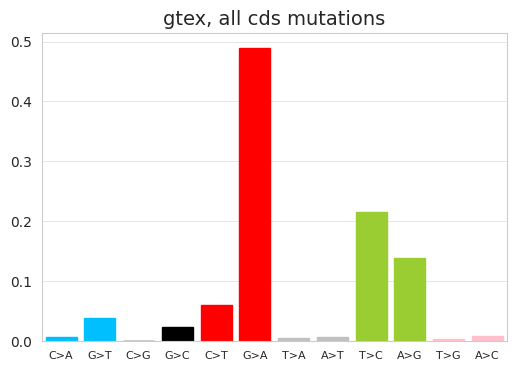

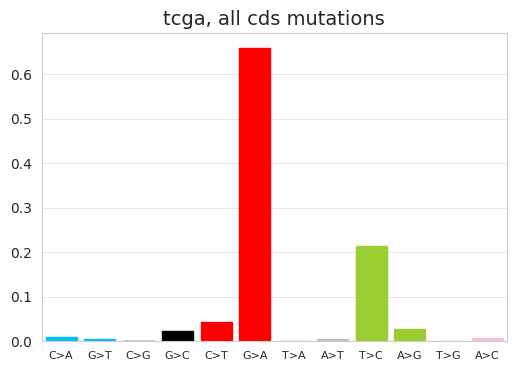

<AxesSubplot:title={'center':'tcga, all cds mutations'}>

In [12]:
plot_mutspec12(ms_gtex_all, title="gtex, all cds mutations")
plot_mutspec12(ms_tcga_all, title="tcga, all cds mutations")

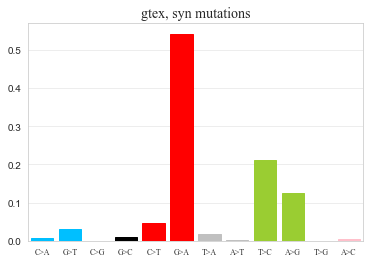

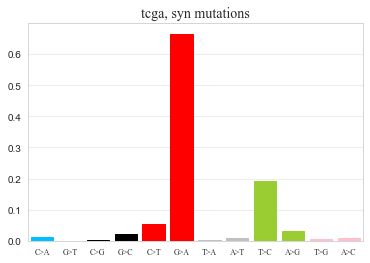

<AxesSubplot:title={'center':'tcga, syn mutations'}>

In [183]:
plot_mutspec12(ms_gtex_syn, title="gtex, syn mutations")
plot_mutspec12(ms_tcga_syn, title="tcga, syn mutations")

### tcga VS gtex - all cds mutations

In [13]:
compare_all = ms_gtex_all.merge(ms_tcga_all, on="Mut", suffixes=["_gtex", "_tcga"]).drop(["RawMutSpec_gtex", "RawMutSpec_tcga"], axis=1)#.sum(axis=0)
compare_all["ObsNum_gtex_percent"] = compare_all["ObsNum_gtex"] / compare_all["ObsNum_gtex"].sum() * 100
compare_all["ObsNum_tcga_percent"] = compare_all["ObsNum_tcga"] / compare_all["ObsNum_tcga"].sum() * 100
compare_all["ObsNum_percent_diff"] = (compare_all["ObsNum_gtex_percent"] - compare_all["ObsNum_tcga_percent"]).abs()
compare_all["ObsNum_percent_quotient"] = (compare_all["ObsNum_gtex_percent"] / compare_all["ObsNum_tcga_percent"]).abs()
_summa = compare_all.sum(axis=0).head(9)
_summa["Mut"] = "ALL"
x = compare_all.append(_summa, ignore_index=True).round(2).sort_values("ObsNum_percent_quotient").reset_index(drop=True)
x.to_csv("../data/processed/tcga_versus_gtex_all_mutations.csv", index=False)
x

,Mut,ObsNum_gtex,ExpNum_gtex,MutSpec_gtex,ObsNum_tcga,ExpNum_tcga,MutSpec_tcga,ObsNum_gtex_percent,ObsNum_tcga_percent,ObsNum_percent_diff,ObsNum_percent_quotient
0,C>G,0,3581,0.00,8,3583,0.00,0.00,0.19,0.19,0.00
1,G>A,371,1297,0.49,1979,1295,0.66,30.64,46.93,16.29,0.65
2,C>A,16,3581,0.01,83,3583,0.01,1.32,1.97,0.65,0.67
3,T>C,347,2763,0.21,1371,2767,0.21,28.65,32.51,3.86,0.88
4,G>C,18,1297,0.02,68,1295,0.02,1.49,1.61,0.13,0.92
5,A>C,17,3165,0.01,58,3171,0.01,1.40,1.38,0.03,1.02
6,A>T,13,3165,0.01,41,3171,0.01,1.07,0.97,0.10,1.10
7,C>T,128,3581,0.06,361,3583,0.04,10.57,8.56,2.01,1.23
8,T>G,6,2763,0.00,11,2767,0.00,0.50,0.26,0.23,1.90
9,T>A,9,2763,0.01,10,2767,0.00,0.74,0.24,0.51,3.13


### tcga VS gtex - syn mutations

In [14]:
compare_syn = ms_gtex_syn.merge(ms_tcga_syn, on="Mut", suffixes=["_gtex", "_tcga"]).drop(["RawMutSpec_gtex", "RawMutSpec_tcga"], axis=1)#.sum(axis=0)
compare_syn["ObsNum_gtex_percent"] = compare_syn["ObsNum_gtex"] / compare_syn["ObsNum_gtex"].sum() * 100
compare_syn["ObsNum_tcga_percent"] = compare_syn["ObsNum_tcga"] / compare_syn["ObsNum_tcga"].sum() * 100
compare_syn["ObsNum_percent_diff"] = (compare_syn["ObsNum_gtex_percent"] - compare_syn["ObsNum_tcga_percent"]).abs()
compare_syn["ObsNum_percent_quotient"] = (compare_syn["ObsNum_gtex_percent"] / compare_syn["ObsNum_tcga_percent"]).abs()
_summa = compare_syn.sum(axis=0).head(9)
_summa["Mut"] = "ALL"
compare_syn.append(_summa, ignore_index=True).round(2).sort_values("ObsNum_percent_quotient").reset_index(drop=True)
x = compare_syn.append(_summa, ignore_index=True).round(2).sort_values("ObsNum_percent_quotient").reset_index(drop=True)
x.to_csv("../data/stem_and_workers/tcga_versus_gtex_syn_mutations.csv", index=False)
x

,Mut,ObsNum_gtex,ExpNum_gtex,MutSpec_gtex,ObsNum_tcga,ExpNum_tcga,MutSpec_tcga,ObsNum_gtex_percent,ObsNum_tcga_percent,ObsNum_percent_diff,ObsNum_percent_quotient
0,C>G,0,821,0.00,4,820,0.00,0.00,0.48,0.48,0.00
1,T>G,0,260,0.00,3,263,0.01,0.00,0.36,0.36,0.00
2,A>T,2,770,0.00,12,768,0.01,0.38,1.44,1.06,0.26
3,G>C,1,95,0.01,4,96,0.02,0.19,0.48,0.29,0.40
4,A>C,4,770,0.00,12,768,0.01,0.76,1.44,0.68,0.53
5,C>A,7,821,0.01,20,820,0.01,1.33,2.40,1.07,0.55
6,G>A,101,177,0.54,242,178,0.67,19.13,28.98,9.85,0.66
7,C>T,94,1876,0.05,209,1875,0.05,17.80,25.03,7.23,0.71
8,T>C,139,622,0.21,244,625,0.19,26.33,29.22,2.90,0.90
9,A>G,172,1312,0.12,84,1312,0.03,32.58,10.06,22.52,3.24


### TsTv tissie-specific

In [42]:
gtex_tissue2sbs = gtex_filtered[gtex_filtered.Label >= 0].groupby(["tissue",]).Substitution.value_counts().unstack().fillna(0)
for sbs12 in set(possible_sbs12).difference(gtex_tissue2sbs.columns):
    gtex_tissue2sbs[sbs12] = 0
gtex_tissue2sbs = gtex_tissue2sbs[possible_sbs12].astype(int)
gtex_tissue2sbs["Ts"] = gtex_tissue2sbs[transitions].sum(axis=1)
gtex_tissue2sbs["Tv"] = gtex_tissue2sbs[[x for x in gtex_tissue2sbs.columns if x in transversions]].sum(axis=1)
gtex_tissue2sbs["TsTv"] = gtex_tissue2sbs.Ts / gtex_tissue2sbs.Tv

tissue_mapper = {
    "Skin - Not Sun Exposed (Suprapubic)": "Skin",
    "Skin - Sun Exposed (Lower leg)": "Skin",
    "Colon - Sigmoid": "Colon",
    "Colon - Transverse": "Colon",
    "Breast - Mammary Tissue": "Breast",
    "Kidney - Cortex": "Kidney",
    "Brain - Hippocampus": "CNS",
    "Brain - Nucleus accumbens (basal ganglia)": "CNS",
    "Brain - Spinal cord (cervical c-1)": "CNS",
    "": "",
    "": "",
}
gtex_tissue2sbs.index = gtex_tissue2sbs.index.to_series().replace(tissue_mapper)
gtex_tissue2sbs.round(2).replace(np.inf, np.nan).to_csv("../data/stem_and_workers/gtex_tissue2obs.csv")
gtex_tissue2sbs.round(2)

Substitution,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,Ts,Tv,TsTv
tissue,,,,,,,,,,,,,,,
Adipose - Subcutaneous,1,2,2,0,0,3,4,0,6,0,6,0,15,9,1.67
Adipose - Visceral (Omentum),0,3,2,0,0,0,5,0,1,0,3,0,11,3,3.67
Adrenal Gland,1,3,0,0,0,0,4,0,0,0,6,0,13,1,13.00
Artery - Aorta,0,14,0,3,0,8,12,1,0,1,10,0,44,5,8.80
Artery - Coronary,0,0,0,0,0,0,0,0,0,0,1,0,1,0,inf
Artery - Tibial,0,4,1,1,0,6,9,0,0,0,5,0,24,2,12.00
CNS,0,1,0,0,0,0,0,0,0,0,2,0,3,0,inf
CNS,0,0,0,0,0,1,0,0,0,0,0,0,1,0,inf
CNS,0,0,0,0,0,0,2,0,0,0,0,0,2,0,inf


In [41]:
tcga_tissue2sbs = tcga_filtered[tcga_filtered.Label >= 0].groupby(["tissue",]).Sbs12.value_counts().unstack().fillna(0)
for sbs12 in set(possible_sbs12).difference(tcga_tissue2sbs.columns):
    tcga_tissue2sbs[sbs12] = 0
tcga_tissue2sbs = tcga_tissue2sbs[possible_sbs12].astype(int)
tcga_tissue2sbs["Ts"] = tcga_tissue2sbs[transitions].sum(axis=1)
tcga_tissue2sbs["Tv"] = tcga_tissue2sbs[transversions].sum(axis=1)
tcga_tissue2sbs["TsTv"] = tcga_tissue2sbs.Ts / tcga_tissue2sbs.Tv

tissue_mapper2 = {
    "Colon/Rectum": "Colon",
    "": "",
    "": "",
    "": "",
}
tcga_tissue2sbs.index = tcga_tissue2sbs.index.to_series().replace(tissue_mapper2)
tcga_tissue2sbs.round(2).replace(np.inf, np.nan).to_csv("../data/stem_and_workers/tcga_tissue2obs.csv")
tcga_tissue2sbs.round(2)

Sbs12,A>C,A>G,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G,Ts,Tv,TsTv
tissue,,,,,,,,,,,,,,,
Biliary,0,2,1,1,0,7,30,1,0,0,17,0,56,3,18.67
Bladder,1,1,0,1,0,4,25,2,1,0,20,1,50,6,8.33
Bone/SoftTissue,0,5,0,0,0,9,40,1,1,0,27,2,81,4,20.25
Breast,3,19,3,7,1,27,130,7,1,2,158,2,334,26,12.85
CNS,10,8,0,3,0,10,56,1,1,1,62,1,136,17,8.00
Cervix,0,2,0,0,1,5,12,0,0,0,5,0,24,1,24.00
Colon,3,5,3,0,0,19,53,2,0,1,20,0,97,9,10.78
Esophagus,6,12,7,6,0,21,97,4,0,1,70,0,200,24,8.33
Head/Neck,1,2,1,1,0,15,26,4,0,0,15,0,58,7,8.29


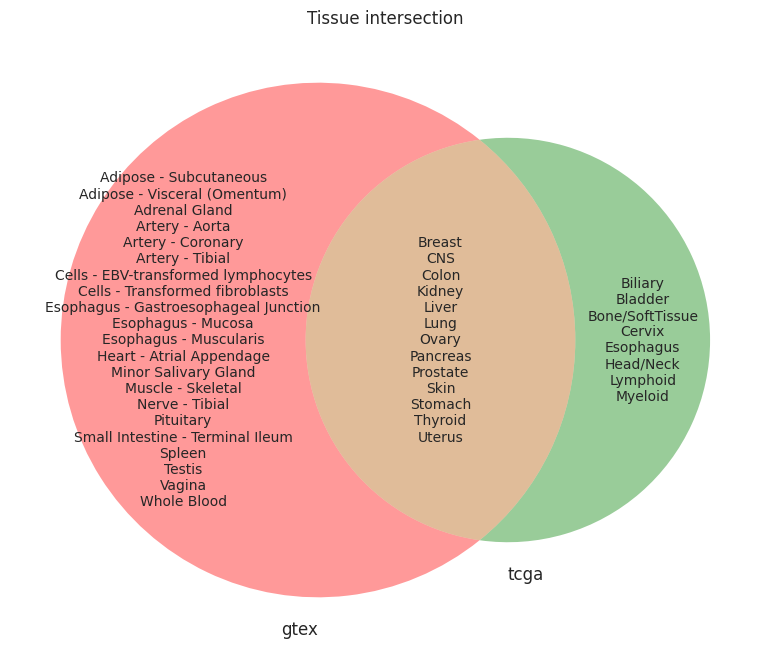

In [43]:
A = set(gtex_tissue2sbs.index)
B = set(tcga_tissue2sbs.index)


plt.figure(figsize=(12, 8))
plt.title("Tissue intersection")
v = venn2([A,B], ('gtex', 'tcga'))

v.get_label_by_id('10').set_text('\n'.join(sorted(A-B)))
v.get_label_by_id('11').set_text('\n'.join(sorted(A&B)))
v.get_label_by_id('01').set_text('\n'.join(sorted(B-A)))
plt.show()

In [25]:
compare_tstv = gtex_tissue2sbs.loc[A&B, ["Ts", "Tv", "TsTv"]].merge(
    tcga_tissue2sbs.loc[A&B, ["Ts", "Tv", "TsTv"]], 
    right_index=True, left_index=True, suffixes=["_gtex", "_tcga"]).reset_index()#.drop_duplicates("tissue")
compare_tstv

,tissue,Ts_gtex,Tv_gtex,TsTv_gtex,Ts_tcga,Tv_tcga,TsTv_tcga
0,Breast,10.0,6.0,1.666667,334.0,26.0,12.846154
1,CNS,3.0,0.0,inf,136.0,17.0,8.000000
2,CNS,1.0,0.0,inf,136.0,17.0,8.000000
3,CNS,2.0,0.0,inf,136.0,17.0,8.000000
4,Colon,9.0,0.0,inf,97.0,9.0,10.777778
5,Colon,3.0,0.0,inf,97.0,9.0,10.777778
6,Kidney,9.0,0.0,inf,394.0,49.0,8.040816
7,Liver,38.0,3.0,12.666667,665.0,39.0,17.051282
8,Lung,19.0,2.0,9.500000,154.0,6.0,25.666667
9,Ovary,28.0,0.0,inf,220.0,13.0,16.923077


In [52]:
compare_tstv = gtex_tissue2sbs.loc[A&B, possible_sbs12].merge(
    tcga_tissue2sbs.loc[A&B, possible_sbs12], 
    right_index=True, left_index=True, suffixes=["_gtex", "_tcga"]).reset_index().groupby("tissue").sum()#.drop_duplicates("tissue")
compare_tstv = compare_tstv[compare_tstv.columns.sort_values()]
compare_tstv.to_csv("../data/stem_and_workers/tissue_specific_compare_obs.csv")
compare_tstv

,A>C_gtex,A>C_tcga,A>G_gtex,A>G_tcga,A>T_gtex,A>T_tcga,C>A_gtex,C>A_tcga,C>G_gtex,C>G_tcga,...,G>C_gtex,G>C_tcga,G>T_gtex,G>T_tcga,T>A_gtex,T>A_tcga,T>C_gtex,T>C_tcga,T>G_gtex,T>G_tcga
tissue,,,,,,,,,,,,,,,,,,,,,
Breast,1,3,1,19,1,3,0,7,0,1,...,0,7,4,1,0,2,4,158,0,2
CNS,0,30,1,24,0,0,0,9,0,0,...,0,3,0,3,0,3,2,186,0,3
Colon,0,6,3,10,0,6,0,0,0,0,...,0,4,0,0,0,2,4,40,0,0
Kidney,0,10,3,29,0,7,0,16,0,0,...,0,10,0,2,0,2,3,112,0,2
Liver,2,6,2,33,0,7,0,12,0,0,...,1,10,0,3,0,1,12,225,0,0
Lung,1,2,6,4,0,0,0,1,0,1,...,0,2,0,0,0,0,5,39,1,0
Ovary,0,2,9,13,0,2,0,2,0,0,...,0,5,0,2,0,0,9,92,0,0
Pancreas,0,1,2,26,1,3,1,12,0,1,...,0,10,0,3,0,0,2,143,0,1
Prostate,0,1,1,10,0,2,0,6,0,1,...,0,3,0,0,0,2,13,138,0,2


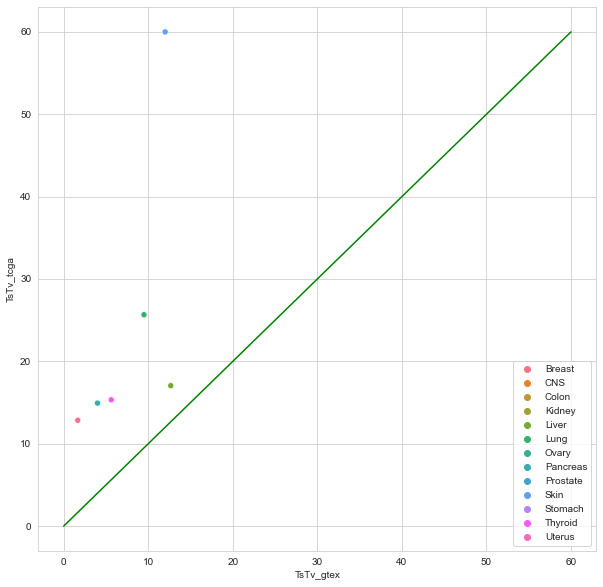

In [351]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=compare_tstv, x="TsTv_gtex", y = "TsTv_tcga", hue="tissue")
sns.lineplot(x=[0, 60], y=[0, 60], color="green")
# plt.xlim((0.6, 1.01))
# plt.ylim((0.6, 1.01))
plt.legend(loc="lower right")
plt.show()

In [323]:
compare_tstv.sum(axis=0)

tissue       BreastCNSCNSCNSColonColonKidneyLiverLungOvaryP...
Ts_gtex                                                  272.0
Tv_gtex                                                  298.0
TsTv_gtex                                            15.964209
Ts_tcga                                                 3740.0
Tv_tcga                                                 4011.0
TsTv_tcga                                            15.856633
dtype: object